In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
from importlib import reload
from icedef import test_case, metocean, simulator, drift
from icedef import statoil_arcticnet_data as statoil_data

# Beacon Data

In [2]:
beacon_metadata_url = 'http://icedef.munroelab.ca/data/StatoilArcticNet/drift_tracks/MunroeMetadata.csv'
beacon_metadata = pd.read_csv(beacon_metadata_url)
beacon_metadata.head()

,BeaconID,IMEI,ArgosID,WMO,DataOwner,DataSharingRestrictions,Contact,BeaconType,Manufacturer,Transmitter,...,RelatedBeaconIDs,AdditionalDatasets,Project,Photos_Y_N,NumberPhotos,PhotoCredits,PhotoRestrictions,PhotoComments,PhotoNames,Comments
0,204980,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"906790, 2790480, 2792490","sail/keel mapping with laser and multibeam, CT...",Statoil/ArcticNet Research Cruise 2015,Y,7,"Derek Mueller, Anna Crawford",4,NaN,"204980_2015_approaching the saddle berg 1.JPG,...",Beacon deployed during ArcticNet/Statoil/WIRL ...
1,505190,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"907780, 2791420","photogrammetry, laser scanning",Statoil/ArcticNet Research Cruise 2015,Y,10,"Derek Mueller, Anna Crawford",4,NaN,"505190_2015_Approaching tabular berg.JPG, 5051...",Beacon deployed during ArcticNet/Statoil/WIRL ...
2,906790,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"204980, 2790480, 2792490","sail/keel mapping with laser and multibeam, CT...",Statoil/ArcticNet Research Cruise 2015,Y,See 204980,See 204980,4,NaN,see 204980,Beacon deployed during ArcticNet/Statoil/WIRL ...
3,907780,300000000000000,NaN,NaN,"Water and Ice Research Laboratory, Carleton Un...",1,Derek Mueller,FT-2000,Solara,Iridium,...,"505190, 2791420","photogrammetry, laser scanning",Statoil/ArcticNet Research Cruise 2015,Y,See 505190,See 505190,4,NaN,see 505190,Beacon deployed during ArcticNet/Statoil/WIRL ...


In [3]:
def get_beacon_df(beacon_id):
    
    url = f'http://icedef.munroelab.ca/data/StatoilArcticNet/drift_tracks/0{beacon_id}_2015.csv'
    
    return pd.read_csv(url, parse_dates=['DataDate_UTC'])

beacon_id_list = list(beacon_metadata['BeaconID'].values)

beacon_df_dict = {}
beacon_ds_dict = {}

for beacon_id in beacon_id_list:
    
    beacon_df_dict[f'{beacon_id}'] = get_beacon_df(beacon_id)
    beacon_ds_dict[f'{beacon_id}'] = get_beacon_df(beacon_id).set_index('DataDate_UTC').to_xarray()

In [4]:
beacon_df_dict['204980'].head()

,BeaconID,BeaconType,DataDate_UTC,TransmissionDate_UTC,Latitude,Longitude,VBatt,AT,ST,BP,Heading,Speed,LocAccuracy,MessageIndex,Satellites,GPSdelay,SNR,TTFF
0,204980,Solara,2015-04-24 15:16:06,NaN,51.45991,-51.55144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,204980,Solara,2015-04-24 15:16:40,NaN,51.45991,-51.55163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,204980,Solara,2015-04-24 15:17:14,NaN,51.45993,-51.55161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,204980,Solara,2015-04-24 15:17:48,NaN,51.45980,-51.55176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,204980,Solara,2015-04-24 15:18:14,NaN,51.46008,-51.55156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


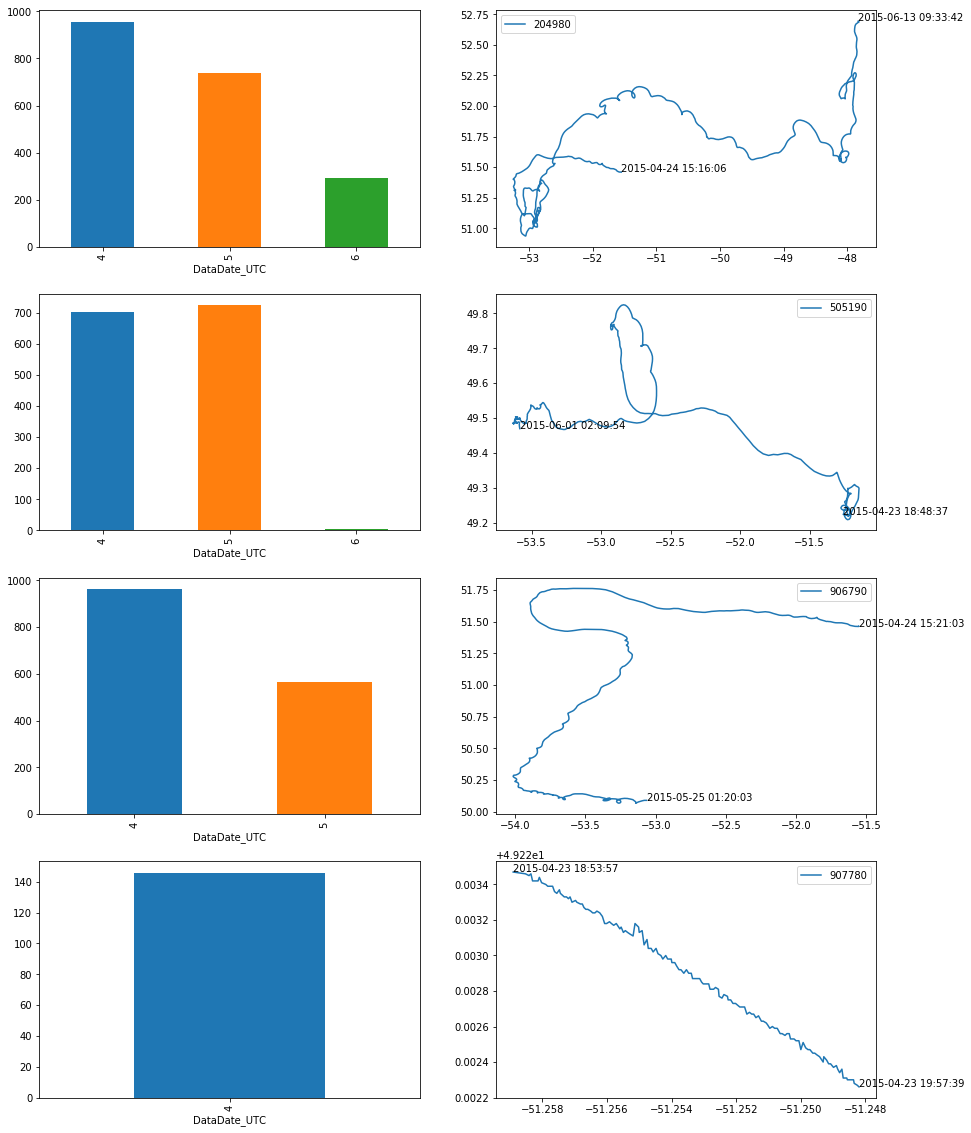

In [5]:
plt.figure(figsize=(15, 20))
i = 1
for key, df in beacon_df_dict.items():
    num_dfs = len(beacon_df_dict.keys())
    plt.subplot(num_dfs, 2, i)
    df['DataDate_UTC'].groupby(df['DataDate_UTC'].dt.month).count().plot(kind="bar", label=key)
    plt.subplot(num_dfs, 2, i + 1)
    plt.plot(df['Longitude'], df['Latitude'], label=key)
    plt.annotate(df['DataDate_UTC'][0], (df['Longitude'][0], df['Latitude'][0]))
    n = len(df)
    plt.annotate(df['DataDate_UTC'][n-1], (df['Longitude'][n-1], df['Latitude'][n-1]))
    plt.legend()
    i += 2
plt.show()

# AVOS Data

In [6]:
avos_df = pd.read_csv('http://icedef.munroelab.ca/data/StatoilArcticNet/AVOS_2015.csv', sep=' ; ')
bad_rows = np.where((avos_df['Longitude'] > 180) | (avos_df['Longitude'] < -180) |
                    (avos_df['Latitude'] > 180) | (avos_df['Latitude'] < -180))[0]

avos_df = avos_df.drop(avos_df.index[bad_rows])
avos_df['Date'] = avos_df['Date'].str.replace('/', '-')
avos_df['Date'] = pd.to_datetime(avos_df['Date'])
avos_df['Wind speed'] = pd.to_numeric(avos_df['Wind speed'])
avos_df['Wind dir'] = pd.to_numeric(avos_df['Wind dir'])

avos_ds = avos_df.set_index('Date').to_xarray()

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [7]:
min(avos_df['Date']), max(avos_df['Date'])

(Timestamp('2015-04-16 00:00:00'), Timestamp('2015-11-01 23:00:00'))

# ADCP Data

In [8]:
file_loc, message = urlretrieve('http://icedef.munroelab.ca/data/StatoilArcticNet/Leg1_1501_ADCP/an1501_os150bb.nc')

In [9]:
adcp_ds = xr.open_dataset(file_loc)

In [10]:
min(adcp_ds.time.values), max(adcp_ds.time.values) 

(numpy.datetime64('2015-04-17T12:32:17.000000000'),
 numpy.datetime64('2015-05-03T10:24:40.000000000'))

# Data Subsets

In [11]:
beacon_subset_dict = {}

for key, ds in beacon_ds_dict.items():
    
        beacon_subset_dict[key] = ds.where((ds.Latitude > 40) & (ds.Latitude < 60) & \
                                          (ds.Longitude > -60) & (ds.Longitude < -40), drop=True)

In [12]:
adcp_subset = adcp_ds.where((adcp_ds.lat < 60) & (adcp_ds.lat > 40) & \
                            (adcp_ds.lon < -40) & (adcp_ds.lon > -60) & \
                            (adcp_ds.u < 10) & (adcp_ds.u > -10) & \
                            (adcp_ds.v < 10) & (adcp_ds.v > -10), drop=True)

In [13]:
avos_subset = avos_ds.where((avos_ds['Latitude'] < 60) & (avos_ds['Latitude'] > 40) & \
                           (avos_ds['Longitude'] < -40) & (avos_ds['Longitude'] > -60), drop=True)

avos_subset = avos_subset.where(avos_subset['Date'] < adcp_subset['time'].values[-1], drop=True)

In [14]:
min_time = max([avos_subset['Date'].min(), adcp_ds['time'].min()]).values
max_time = min([avos_subset['Date'].max(), adcp_ds['time'].max()]).values

In [15]:
min_time, max_time

(numpy.datetime64('2015-04-19T08:00:00.000000000'),
 numpy.datetime64('2015-04-30T03:00:00.000000000'))

In [16]:
adcp_subset = adcp_subset.where((adcp_subset['time'] >= min_time) & (adcp_subset['time'] <= max_time), drop=True)
avos_subset = avos_subset.where((avos_subset['Date'] >= min_time) & (avos_subset['Date'] <= max_time), drop=True)

for key, ds in beacon_subset_dict.items():
    
        beacon_subset_dict[key] = ds.where((ds['DataDate_UTC'] >= min_time) & \
                                           (ds['DataDate_UTC'] <= max_time), drop=True)

In [17]:
beacon_df_dict['204980'].head()

,BeaconID,BeaconType,DataDate_UTC,TransmissionDate_UTC,Latitude,Longitude,VBatt,AT,ST,BP,Heading,Speed,LocAccuracy,MessageIndex,Satellites,GPSdelay,SNR,TTFF
0,204980,Solara,2015-04-24 15:16:06,NaN,51.45991,-51.55144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,204980,Solara,2015-04-24 15:16:40,NaN,51.45991,-51.55163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,204980,Solara,2015-04-24 15:17:14,NaN,51.45993,-51.55161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,204980,Solara,2015-04-24 15:17:48,NaN,51.45980,-51.55176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,204980,Solara,2015-04-24 15:18:14,NaN,51.46008,-51.55156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


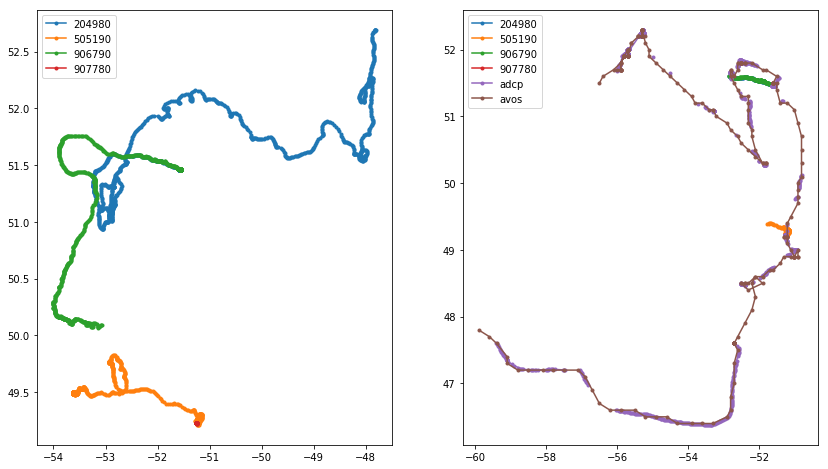

In [18]:
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
for key, ds in beacon_ds_dict.items():
    plt.plot(ds['Longitude'], ds['Latitude'], '.-', label=key)
plt.legend()

plt.subplot(1, 2, 2)
for key, ds in beacon_subset_dict.items():    
    plt.plot(ds['Longitude'], ds['Latitude'], '.-', label=key)
plt.plot(adcp_subset['lon'].values[:, 0], adcp_subset['lat'].values[:, 0], '.-', label='adcp')
plt.plot(avos_subset['Longitude'].values, avos_subset['Latitude'].values, '.-', label='avos')
plt.legend()

plt.show()

# Time Series Vector Plots

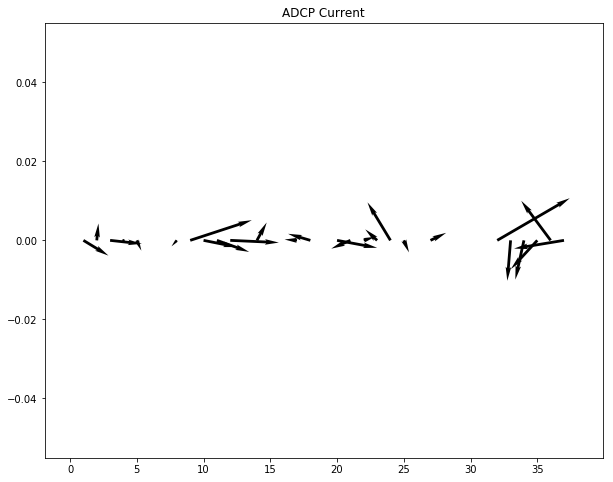

In [19]:
plt.figure(figsize=(10, 8))
gap = 50
plt.quiver(np.arange(len(adcp_subset['time'][::gap])), np.arange(len(adcp_subset['time'][::gap])) * 0, 
           adcp_subset['u'][::gap, 0], adcp_subset['v'][::gap, 0], headwidth=2, width=0.005, angles='uv')
plt.title('ADCP Current')
plt.show()

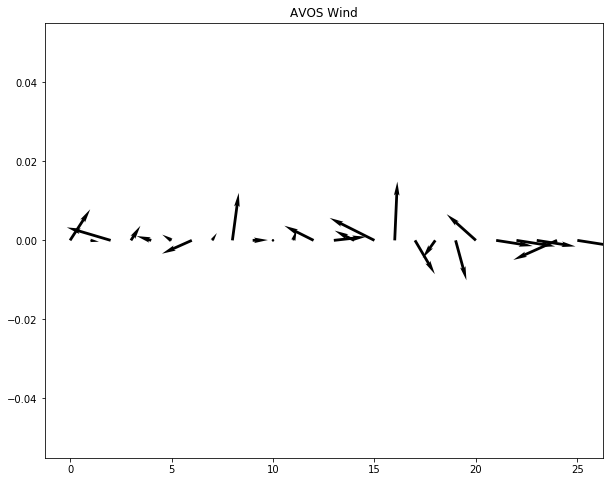

In [20]:
plt.figure(figsize=(10, 8))
gap = 10
avos_subset_u = -avos_subset['Wind speed'] * np.sin(avos_subset['Wind dir'])
avos_subset_v = -avos_subset['Wind speed'] * np.cos(avos_subset['Wind dir'])
plt.quiver(np.arange(len(avos_subset['Date'][::gap])), np.arange(len(avos_subset['Date'][::gap])) * 0, 
           avos_subset_u[::gap], avos_subset_v[::gap], headwidth=2, width=0.005, angles='uv')
plt.title('AVOS Wind')
plt.show()

# Compare by Interpolating

In [21]:
date_bounds = min_time, max_time 
ocean = metocean.ECMWFOcean(date_bounds)
atm = metocean.NARRAtmosphere(date_bounds)

### Current

In [22]:
adcp_subset.u[100:200, 0]

<xarray.DataArray 'u' (time: 100)>
array([ 0.009325,  0.017314, -0.0014  ,  0.018642,  0.009318,  0.007811,
        0.061733,  0.011993, -0.006536, -0.052452, -0.102835, -0.025994,
       -0.038184,  0.006215,       nan,  0.072725,  0.028601,  0.053706,
        0.007897, -0.026674, -0.007829, -0.032264, -0.012919, -0.005905,
        0.034016, -0.022858, -0.011607, -0.018801, -0.00354 , -0.044971,
       -0.029185, -0.004115, -0.021322,  0.006738, -0.069387, -0.133959,
        0.201135,  0.063921,  0.101437,  0.127542,  0.117774,  0.125811,
        0.120375,  0.107413,  0.1195  ,  0.19816 ,  0.112181,  0.152645,
        0.175369,  0.125058,  0.175363,  0.132848,  0.128117,  0.13387 ,
        0.124569,  0.151783,  0.207336,  0.170722,  0.140471,  0.131053,
        0.132334,  0.155229,  0.173038,  0.129732,  0.14531 ,  0.099728,
        0.08759 ,  0.0893  ,  0.080082,  0.082882,  0.08267 ,  0.116318,
        0.064731,  0.080369,  0.070024,  0.091661,  0.117514,  0.073298,
        0.118594

In [23]:
adcp_subset.u.values[:, 0]

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [24]:
adcp_subset.lon

<xarray.DataArray 'lon' (time: 1934, depth_cell: 30)>
array([[       nan, -59.951389, -59.951389, ..., -59.951389, -59.951389,
        -59.951389],
       [       nan, -59.920797, -59.920797, ..., -59.920797, -59.920797,
        -59.920797],
       [       nan, -59.890319, -59.890319, ..., -59.890319, -59.890319,
        -59.890319],
       ...,
       [       nan, -56.489403, -56.489403, ...,        nan,        nan,
               nan],
       [       nan, -56.500244, -56.500244, ...,        nan,        nan,
               nan],
       [       nan, -56.514728, -56.514728, ...,        nan,        nan,
               nan]])
Coordinates:
  * time     (time) datetime64[ns] 2015-04-19T08:03:53 2015-04-19T08:08:54 ...
Dimensions without coordinates: depth_cell
Attributes:
    C_format:       %9.4f
    long_name:      Longitude
    standard_name:  longitude
    data_min:       -71.197
    units:          degrees_east
    data_max:       -50.7460638888889

In [25]:
u_list = []
v_list = []
good_times = []
good_lats = []
good_lons = []
u_adcp_list = []
v_adcp_list = []

for i in range(len(adcp_subset.time) - 1):
    if abs(adcp_subset.u.values[i, 0]) < 10 and abs(adcp_subset.u.values[i, 0]) < 10:
        
        try:
            u_list.append(ocean.eastward_current_velocities.interp(time=adcp_subset.time.values[i], 
                                                                   latitude=adcp_subset.lat.values[i, 0], 
                                                                   longitude=adcp_subset.lon.values[i, 0], 
                                                                   assume_sorted=True).values)

            v_list.append(ocean.northward_current_velocities.interp(time=adcp_subset.time.values[i], 
                                                                    latitude=adcp_subset.lat.values[i, 0], 
                                                                    longitude=adcp_subset.lon.values[i, 0], 
                                                                    assume_sorted=True).values)
            good_times.append(adcp_subset.time.values[i])
            good_lats.append(adcp_subset.lat.values[i, 0])
            good_lons.append(adcp_subset.lon.values[i, 0])

            u_adcp_list.append(adcp_subset.u.values[i, 0])
            v_adcp_list.append(adcp_subset.v.values[i, 0])
        
        except KeyError:
            pass

ocean_interp_ds = xr.Dataset({'u': (['time'], u_list), 'v': (['time'], v_list)},
                             coords={'time': good_times, 'lat': good_lats, 'lon': good_lons})

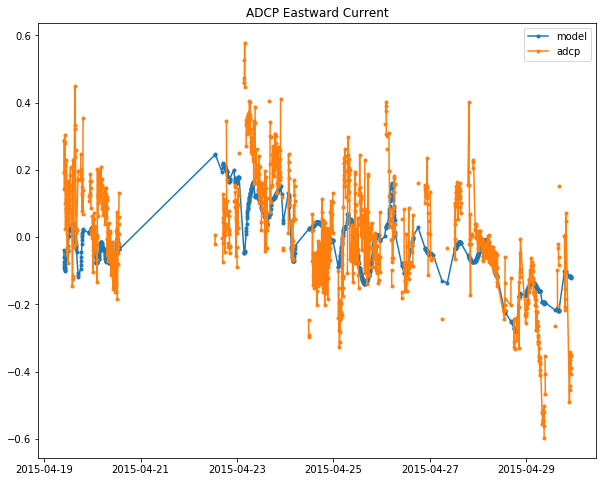

In [26]:
plt.figure(figsize=(10, 8))
plt.plot(ocean_interp_ds.time.values, ocean_interp_ds.u.values, '.-', label='model')
plt.plot(adcp_subset['time'].values, adcp_subset.u[:, 0].values, '.-', label='adcp')
plt.title('ADCP Eastward Current')
plt.legend()
plt.show()

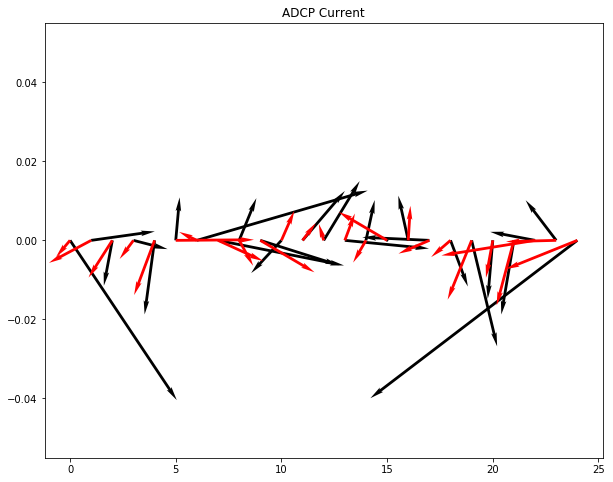

In [27]:
# Y-AXIS LABELS ARE WRONG

plt.figure(figsize=(10, 8))
gap = 50
scale = 1.5
plt.quiver(u_adcp_list[::gap], v_adcp_list[::gap], 
           headwidth=2, width=0.005, angles='uv', scale=scale, label='adcp')
plt.quiver(ocean_interp_ds['u'][::gap], ocean_interp_ds['v'][::gap], 
           headwidth=2, width=0.005, angles='uv', color='red', scale=scale, label='model')
plt.title('ADCP Current')
plt.show()

### Wind

In [28]:
u_list = []
v_list = []
good_times = []
good_lats = []
good_lons = []


for i in range(len(avos_subset['Date']) - 1):
    try:
        u_list.append(atm.eastward_wind_velocities.interp(time=avos_subset['Date'].values[i], 
                                                          latitude=avos_subset['Latitude'].values[i], 
                                                          longitude=avos_subset['Longitude'].values[i], 
                                                          assume_sorted=True).values)
        
        v_list.append(atm.northward_wind_velocities.interp(time=avos_subset['Date'].values[i], 
                                                           latitude=avos_subset['Latitude'].values[i], 
                                                           longitude=avos_subset['Longitude'].values[i], 
                                                           assume_sorted=True).values)
        good_times.append(avos_subset['Date'].values[i])
        good_lats.append(avos_subset['Latitude'].values[i])
        good_lons.append(avos_subset['Longitude'].values[i])
        
    except KeyError:
        pass

atm_interp_ds = xr.Dataset({'u': (['time'], u_list), 'v': (['time'], v_list)},
                           coords={'time': good_times, 'lat': good_lats, 'lon': good_lons})

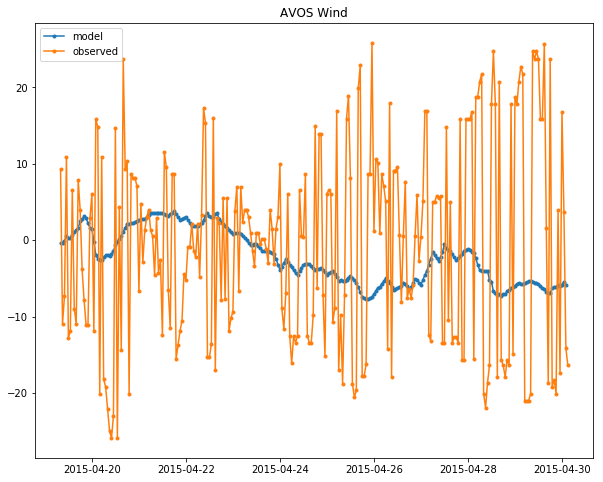

In [29]:
plt.figure(figsize=(10, 8))
plt.plot(atm_interp_ds.time.values, atm_interp_ds.u.values, '.-', label='model')
plt.plot(avos_subset['Date'].values, avos_subset_u, '.-', label='observed')
plt.title('AVOS Wind')
plt.legend()
plt.show()

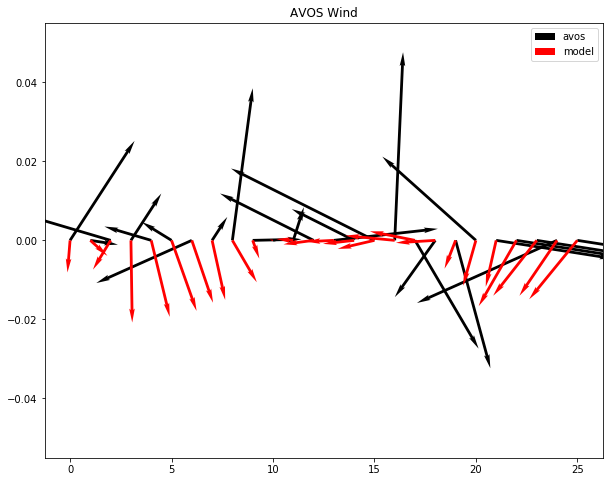

In [30]:
# Y-AXIS LABELS ARE WRONG

plt.figure(figsize=(10, 8))
gap = 10
scale = 80
plt.quiver(avos_subset_u[::gap], avos_subset_v[::gap], 
           headwidth=2, width=0.005, angles='uv', scale=scale, label='avos')
plt.quiver(atm_interp_ds['u'][::gap], atm_interp_ds['v'][::gap], 
           headwidth=2, width=0.005, angles='uv', color='red', scale=scale, label='model')
plt.title('AVOS Wind')
plt.legend()
plt.show()

### Wind and Current

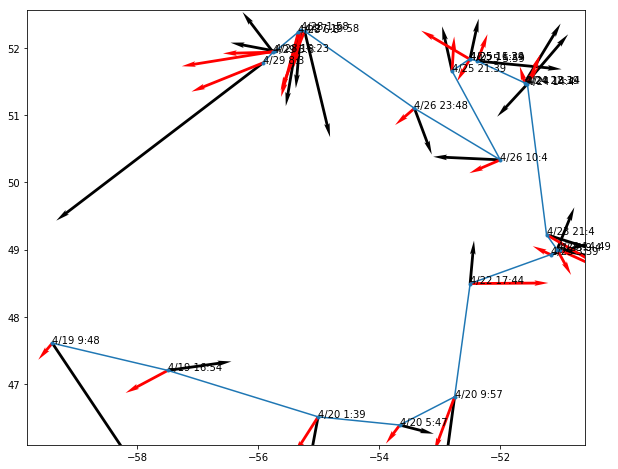

In [31]:
plt.figure(figsize=(10, 8))
gap = 50
scale = 1.5
plt.plot(ocean_interp_ds['lon'].values[::gap], ocean_interp_ds['lat'].values[::gap], '.-')

for i in np.arange(0, len(ocean_interp_ds['time']), gap):
    time = pd.Timestamp(ocean_interp_ds['time'].values[i])
    annotation = f'{time.month}/{time.day} {time.hour}:{time.minute}'
    plt.annotate(annotation, 
                 (ocean_interp_ds['lon'].values[i], ocean_interp_ds['lat'].values[i]))

plt.quiver(ocean_interp_ds['lon'].values[::gap], ocean_interp_ds['lat'].values[::gap],
           u_adcp_list[::gap], v_adcp_list[::gap], headwidth=2, width=0.005, angles='uv',
           scale=scale)
plt.quiver(ocean_interp_ds['lon'].values[::gap], ocean_interp_ds['lat'].values[::gap],
           ocean_interp_ds['u'][::gap], ocean_interp_ds['v'][::gap], headwidth=2, width=0.005, angles='uv', 
           color='red', scale=scale)
plt.show()

# Plotting ADCP at Depth

In [32]:
adcp_subset.lat[:10, 1]

<xarray.DataArray 'lat' (time: 10)>
array([47.780644, 47.779014, 47.777239, 47.775525, 47.773678, 47.771753,
       47.770156, 47.767639, 47.764694, 47.760467])
Coordinates:
  * time     (time) datetime64[ns] 2015-04-19T08:03:53 2015-04-19T08:08:54 ...
Attributes:
    C_format:       %9.4f
    long_name:      Latitude
    standard_name:  latitude
    data_min:       46.376980555555555
    units:          degrees_north
    data_max:       52.301858333333335

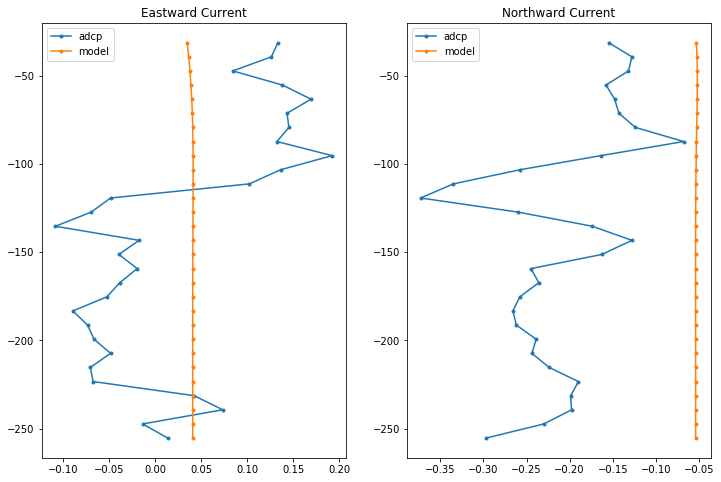

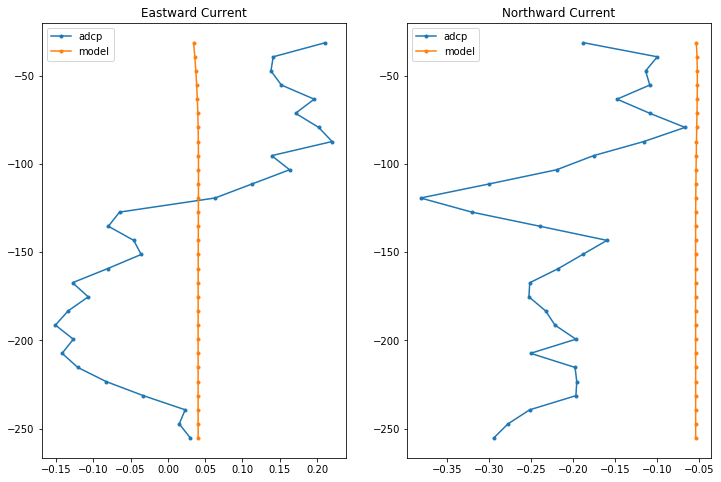

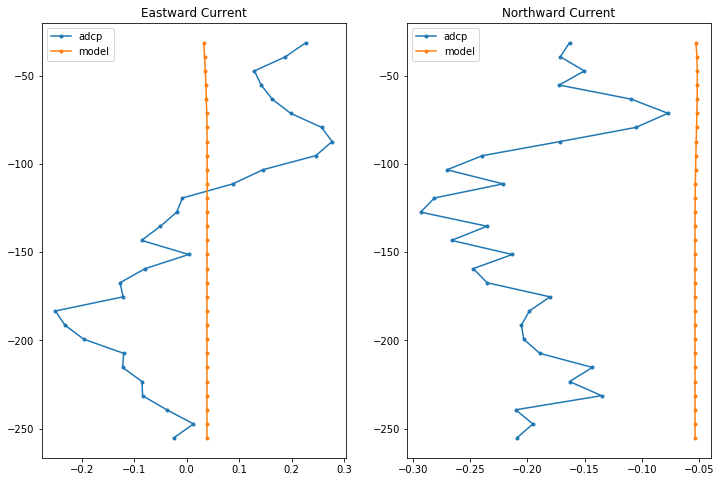

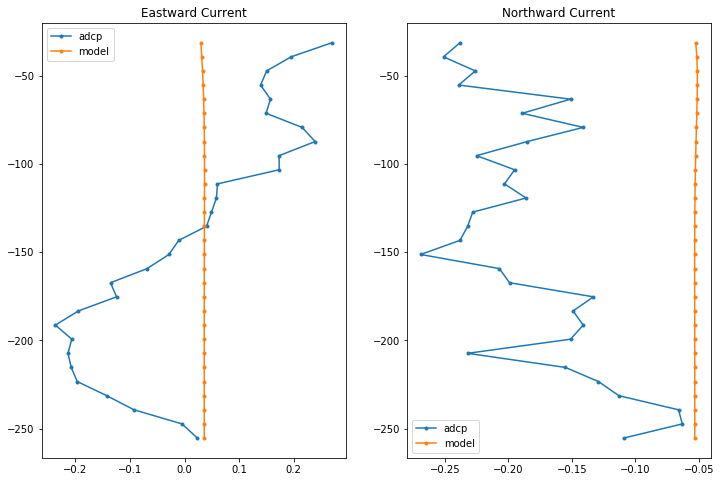

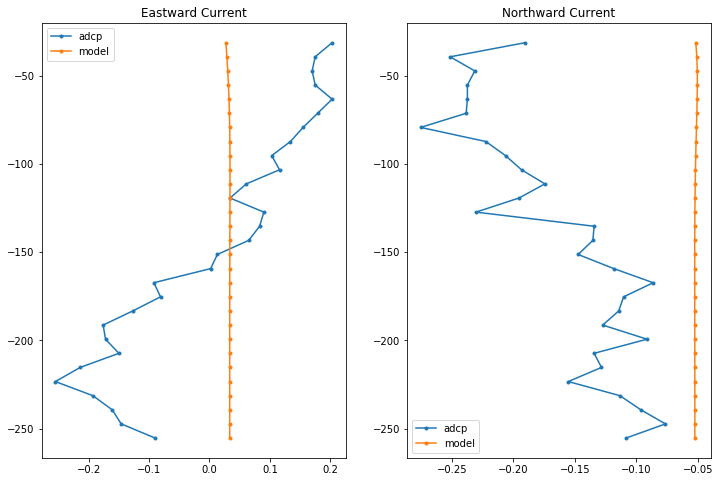

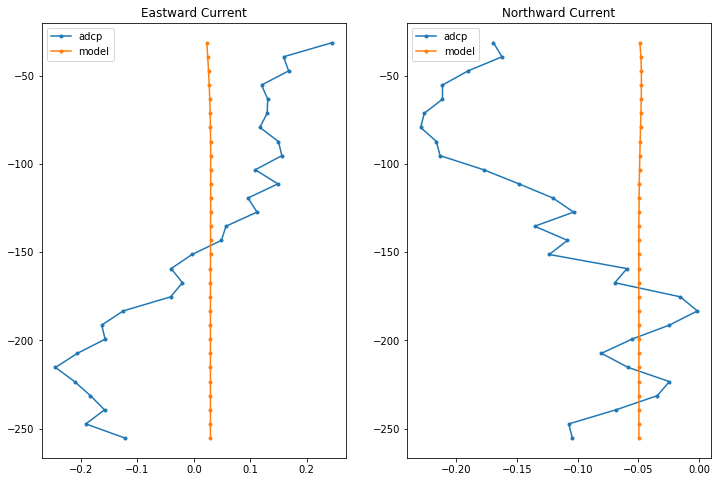

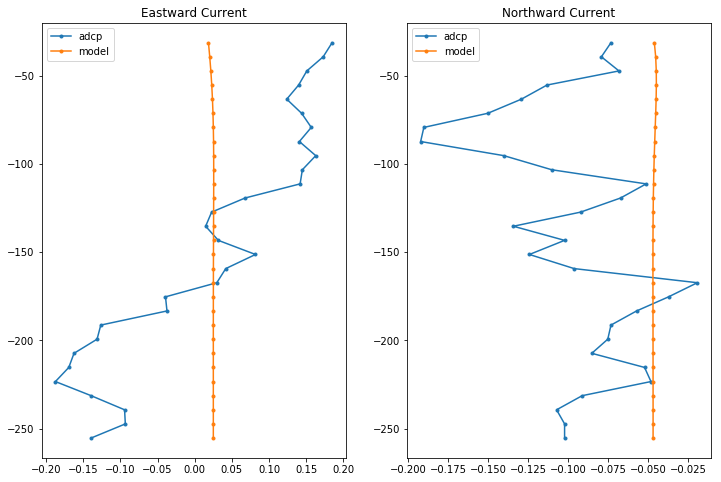

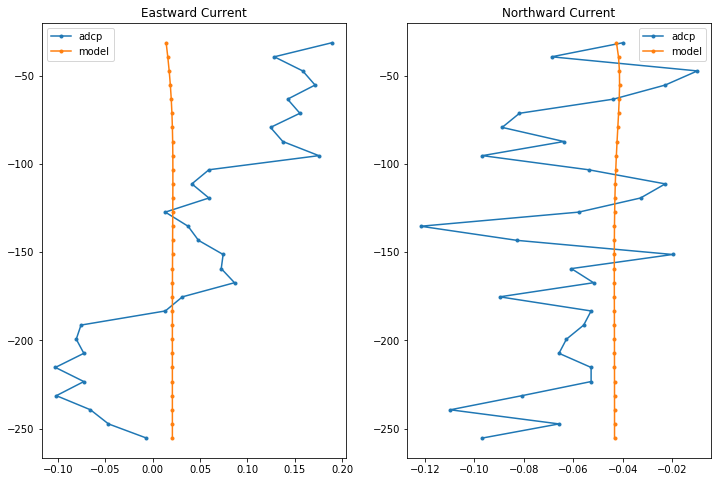

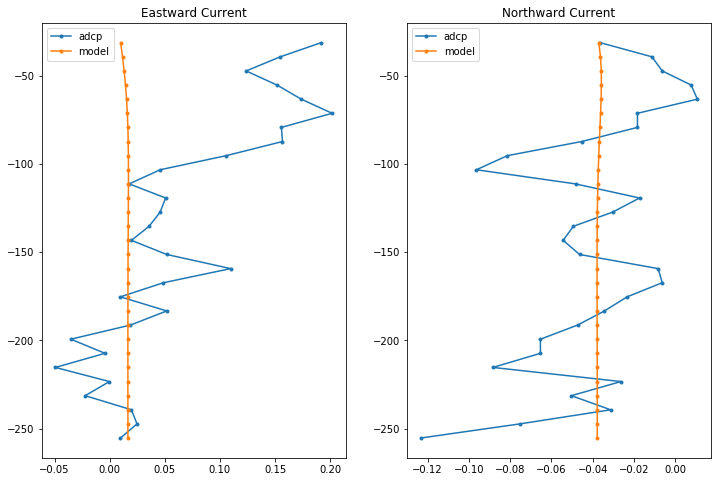

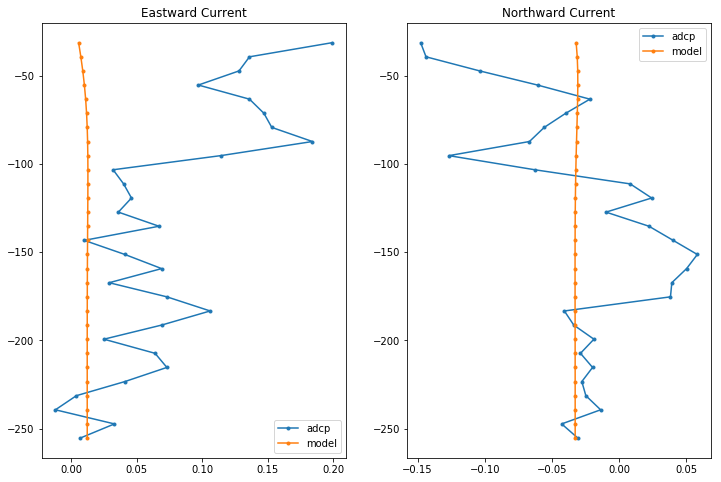

In [33]:
for i in range(10):

    time = adcp_subset.time.values[i]
    latitude = adcp_subset.lat.values[i, 1]
    longitude = adcp_subset.lon.values[i, 1]
    depth_vec = -adcp_subset.depth.values[i, :35]

    try:
        surface_current_u = float(ocean.eastward_current_velocities.interp(time=time, latitude=latitude, longitude=longitude, 
                                                                     assume_sorted=True).values)

        surface_current_v = float(ocean.northward_current_velocities.interp(time=time, latitude=latitude, longitude=longitude, 
                                                                     assume_sorted=True).values)

        wind_u = float(atm.eastward_wind_velocities.interp(time=time, latitude=latitude, longitude=longitude, 
                                                     assume_sorted=True).values)

        wind_v = float(atm.northward_wind_velocities.interp(time=time, latitude=latitude, longitude=longitude, 
                                                      assume_sorted=True).values)

        wind = wind_u, wind_v
        surface_current = surface_current_u, surface_current_v
        current_u_vec, current_v_vec = drift.compute_ekman_spiral(wind, surface_current, depth_vec, latitude)

        plt.figure(figsize=(12, 8))

        plt.subplot(1, 2, 1)
        plt.title('Eastward Current')
        plt.plot(adcp_subset.u[i, :], -adcp_subset.depth[i, :], '.-', label='adcp') 
        plt.plot(current_u_vec, depth_vec, '.-', label='model')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title('Northward Current')
        plt.plot(adcp_subset.v[i, :], -adcp_subset.depth[i, :], '.-', label='adcp') 
        plt.plot(current_v_vec, depth_vec, '.-', label='model')
        plt.legend()

        plt.show()
    
    except KeyError:
        pass

# Simulation

In [34]:
statoil_df = statoil_data.get_df(statoil_data.dir_path, statoil_data.csv_filenames[2])

In [35]:
statoil_df.loc[(statoil_df['DataDate_UTC'] > np.datetime64('2015-04-27')) & (statoil_df['DataDate_UTC'] < np.datetime64('2015-04-29'))]

,BeaconID,BeaconType,DataDate_UTC,TransmissionDate_UTC,Latitude,Longitude,VBatt,AT,ST,BP,Heading,Speed,LocAccuracy,MessageIndex,Satellites,GPSdelay,SNR,TTFF
867,90679,Solara,2015-04-27 00:48:46,NaN,51.53961,-51.95010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
868,90679,Solara,2015-04-27 01:48:39,NaN,51.53945,-51.95645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
869,90679,Solara,2015-04-27 02:48:22,NaN,51.53903,-51.96196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
870,90679,Solara,2015-04-27 03:48:43,NaN,51.53830,-51.96896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
871,90679,Solara,2015-04-27 04:48:28,NaN,51.53709,-51.97600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
872,90679,Solara,2015-04-27 05:48:13,NaN,51.53609,-51.98269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873,90679,Solara,2015-04-27 06:48:16,NaN,51.53544,-51.99016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874,90679,Solara,2015-04-27 07:48:24,NaN,51.53505,-51.99788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875,90679,Solara,2015-04-27 08:48:15,NaN,51.53429,-52.00539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
876,90679,Solara,2015-04-27 09:48:00,NaN,51.53489,-52.01344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
tc = test_case.TestCase(index_range=(867, 914))
start_latitude = tc.start_latitude
start_longitude = tc.start_longitude
start_velocity = tc.start_velocity
start_time = tc.start_time
end_time = tc.end_time
ref_times = tc.ref_times
ref_lons = tc.ref_lons
ref_lats = tc.ref_lats
start_location = (tc.start_latitude, tc.start_longitude)
time_frame = (tc.start_time, tc.end_time)
start_velocity = tc.start_velocity

In [37]:
time_frame

(numpy.datetime64('2015-04-27T00:48:46.000000'),
 numpy.datetime64('2015-04-28T23:46:48.000000'))

In [38]:
sim = simulator.Simulator()

sim.run_simulation(start_location, time_frame, store_results_as='204980')

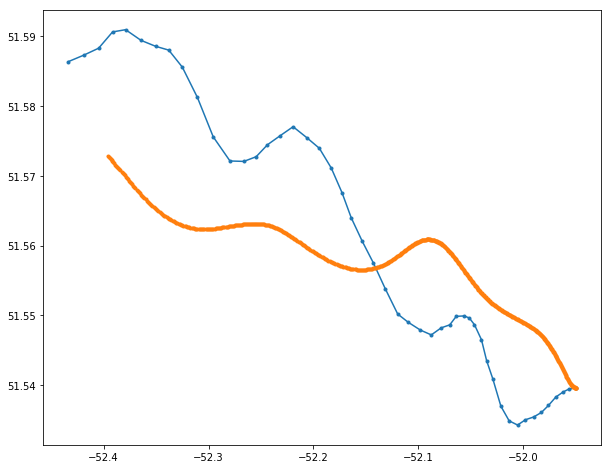

In [39]:
plt.figure(figsize=(10, 8))
plt.plot(ref_lons, ref_lats, '.-')
plt.plot(sim.results['204980']['longitude'], sim.results['204980']['latitude'], '.-')
plt.show()

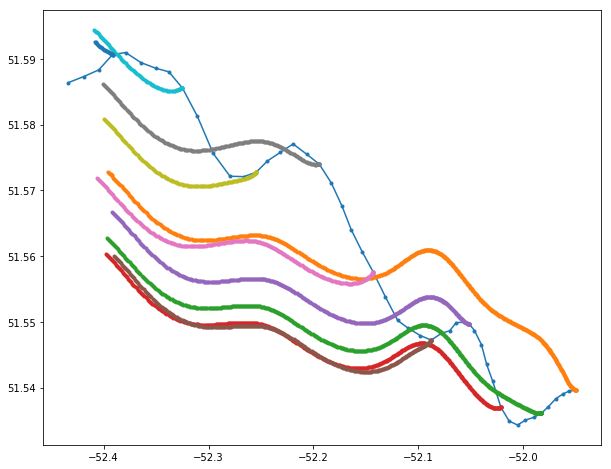

In [40]:
step = 5

plt.figure(figsize=(10, 8))
plt.plot(ref_lons, ref_lats, '.-')

for i in np.arange(0, len(ref_times), step):
    
    sim.run_simulation((ref_lats.values[i], ref_lons.values[i]), (ref_times[i], end_time), 
                       store_results_as=f'204980_{i}')

    plt.plot(sim.results[f'204980_{i}']['longitude'], sim.results[f'204980_{i}']['latitude'], '.-')
    
plt.show()

# Old Code

In [41]:
max_of_mins = max([np.datetime64(min(beacon_df_dict['204980']['DataDate_UTC'])), 
                   np.datetime64(min(avos_df['Date'])), 
                   min(adcp_ds.time.values)])

min_of_maxs = min([np.datetime64(max(beacon_df_dict['204980']['DataDate_UTC'])), 
                   np.datetime64(max(avos_df['Date'])), 
                   max(adcp_ds.time.values)])

max_of_mins, min_of_maxs

(numpy.datetime64('2015-04-24T15:16:06.000000'),
 numpy.datetime64('2015-05-03T10:24:40.000000000'))

In [42]:
beacon_min_index = np.where(beacon_df_dict['204980']['DataDate_UTC'] >= max_of_mins)[0][0]
avos_min_index = np.where(avos_df['Date'] >= max_of_mins)[0][0]
adcp_min_index = np.where(adcp_ds.time.values >= max_of_mins)[0][0]

beacon_min_index, avos_min_index, adcp_min_index

(0, 178, 2023)

In [43]:
beacon_max_index = np.where(beacon_df_dict['204980']['DataDate_UTC'] <= min_of_maxs)[0][-1]
avos_max_index = np.where(avos_df['Date'] <= min_of_maxs)[0][-1]
adcp_max_index = np.where(adcp_ds.time.values <= min_of_maxs)[0][-1]

beacon_max_index, avos_max_index, adcp_max_index

(1011, 387, 4543)

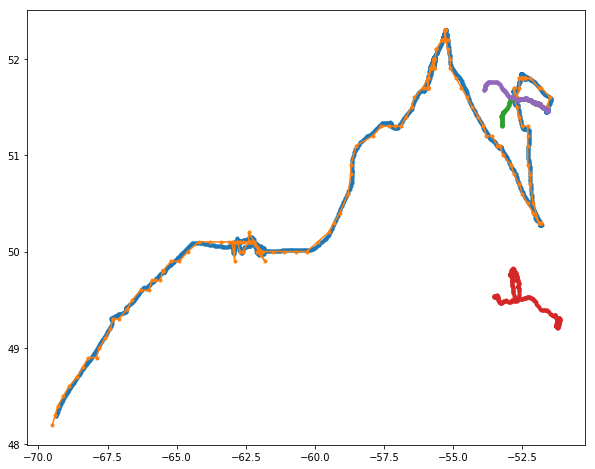

In [44]:
plt.figure(figsize=(10, 8))
plt.plot(adcp_ds.lon[adcp_min_index : adcp_max_index + 1], adcp_ds.lat[adcp_min_index : adcp_max_index + 1], '.-')
plt.plot(avos_df['Longitude'][avos_min_index : avos_max_index + 1], avos_df['Latitude'][avos_min_index : avos_max_index + 1], '.-')
plt.plot(beacon_df_dict['204980']['Longitude'][beacon_min_index : beacon_max_index + 1], 
        beacon_df_dict['204980']['Latitude'][beacon_min_index : beacon_max_index + 1], '.-')
plt.plot(beacon_df_dict['505190']['Longitude'][beacon_min_index : beacon_max_index + 1], 
        beacon_df_dict['505190']['Latitude'][beacon_min_index : beacon_max_index + 1], '.-')
plt.plot(beacon_df_dict['906790']['Longitude'][beacon_min_index : beacon_max_index + 1], 
        beacon_df_dict['906790']['Latitude'][beacon_min_index : beacon_max_index + 1], '.-')
plt.show()

## ADCP Union

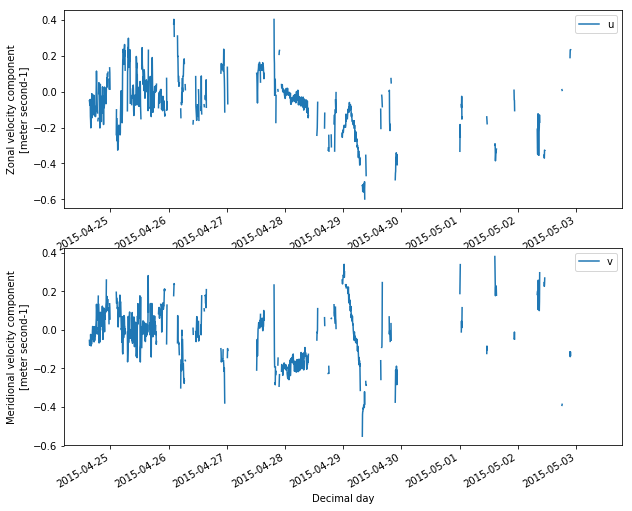

In [45]:
plt.figure(figsize=(10, 8))
keys = 'u', 'v'
for i, key in enumerate(keys):
    plt.subplot(len(keys), 1, i+1)
    adcp_ds[key][adcp_min_index : adcp_max_index + 1][:, 0].plot()
    plt.legend()
plt.show()

In [46]:
np.where(~(np.abs(adcp_ds.u.values[adcp_min_index : adcp_max_index + 1][:, 0] < 10)))[0]

array([  41,   45,   85, ..., 2518, 2519, 2520])

In [47]:
adcp_ds.u.values[adcp_min_index : adcp_max_index + 1][41, 0]

nan

## AVOS Union

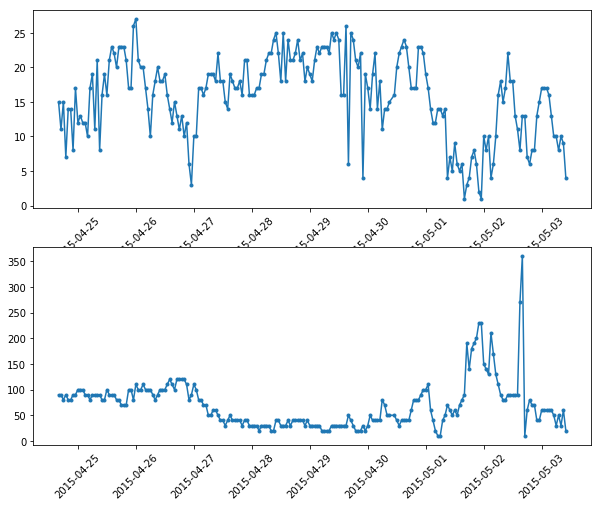

In [48]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(avos_df['Date'][avos_min_index : avos_max_index + 1], 
         avos_df['Wind speed'][avos_min_index : avos_max_index + 1], '.-')
plt.xticks(rotation=45)
plt.subplot(2, 1, 2)
plt.plot(avos_df['Date'][avos_min_index : avos_max_index + 1], 
         avos_df['Wind dir'][avos_min_index : avos_max_index + 1], '.-')
plt.xticks(rotation=45)
plt.show()

## Beacon Union

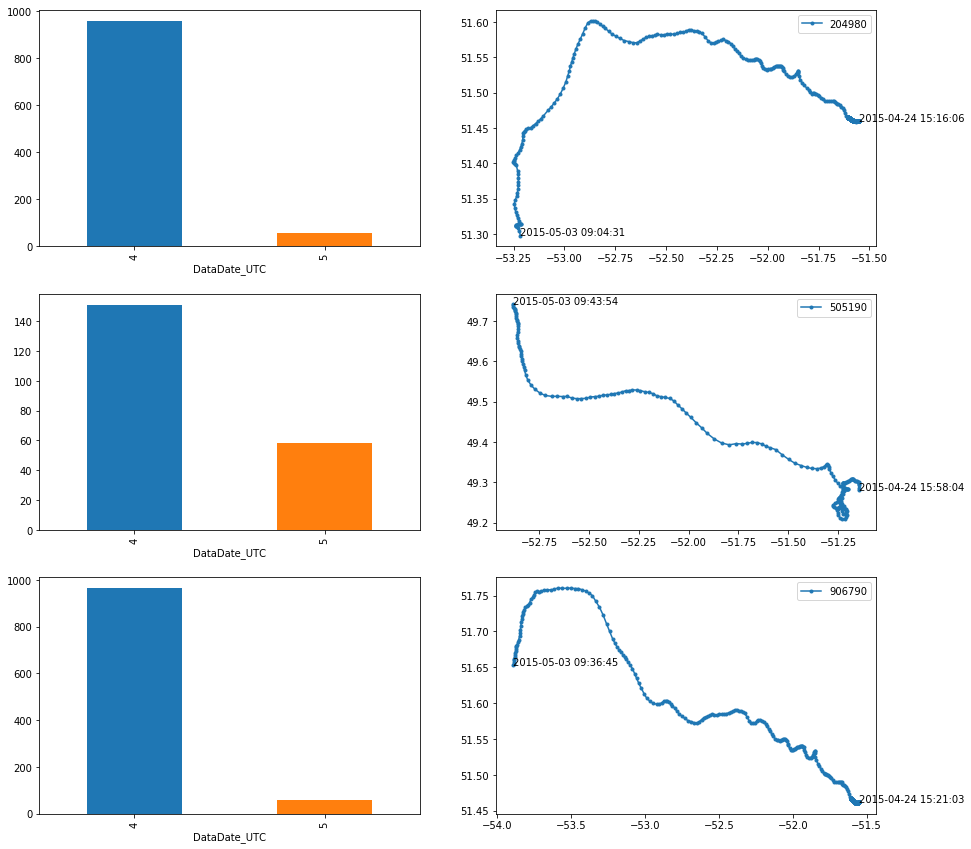

In [49]:
plt.figure(figsize=(15, 20))
num_dfs = len(beacon_df_dict.keys())
i = 1
for key, df in beacon_df_dict.items():
    try:
        beacon_min_index = np.where(df['DataDate_UTC'] >= max_of_mins)[0][0]
        beacon_max_index = np.where(df['DataDate_UTC'] <= min_of_maxs)[0][-1]
        df = df[beacon_min_index : beacon_max_index + 1].reset_index()
        plt.subplot(num_dfs, 2, i)
        df['DataDate_UTC'].groupby(df['DataDate_UTC'].dt.month).count().plot(kind="bar", label=key)
        plt.subplot(num_dfs, 2, i + 1)
        plt.plot(df['Longitude'], df['Latitude'], '.-', label=key)
        plt.annotate(df['DataDate_UTC'][0], (df['Longitude'][0], df['Latitude'][0]))
        n = len(df)
        plt.annotate(df['DataDate_UTC'][n-1], (df['Longitude'][n-1], df['Latitude'][n-1]))
        plt.legend()
    except IndexError:
        pass
    i += 2
plt.show()